## Run inference test
Test with images in repository `object_detection_demo/test` directory.

In [26]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = './frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = './data/annotations/label_map.pbtxt'

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR (./test).
PATH_TO_TEST_IMAGES_DIR = './test'

assert os.path.isfile(PATH_TO_CKPT)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['./test/IMG20191224210543.jpg', './test/IMG20191224211723.jpg', './test/IMG20191224181028.jpg', './test/IMG20191224181032.jpg', './test/IMG20191224181042.jpg', './test/IMG20191224181038.jpg', './test/IMG20191224181024.jpg']


In [27]:
%cd /models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

NUM_CLASSES = 2

detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height,xx) = image.shape
    return np.array(image.reshape(im_height, im_width, 3)).astype(np.uint8)


# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict




[Errno 2] No such file or directory: '/models/research/object_detection'
/home/vinay/Documents/GitHub/object_detection_colab


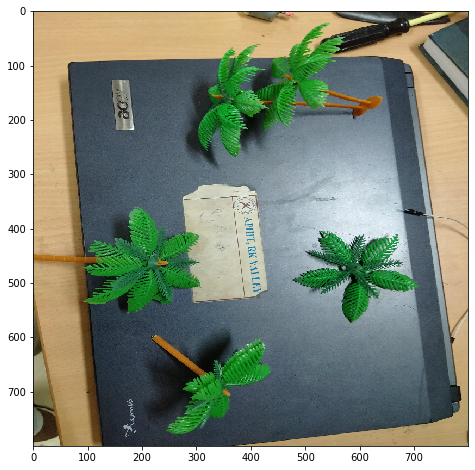

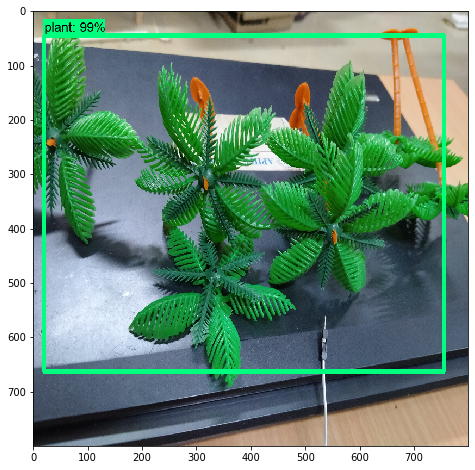

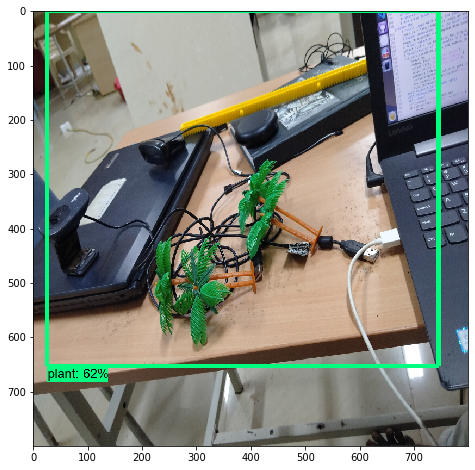

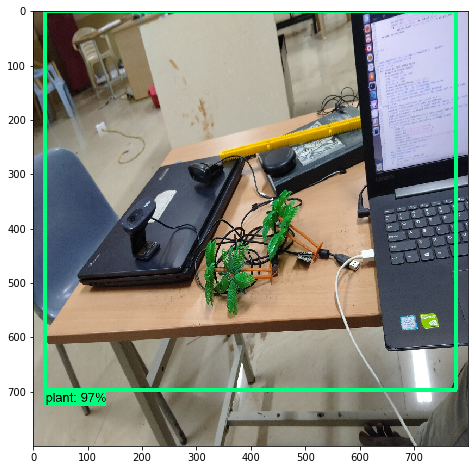

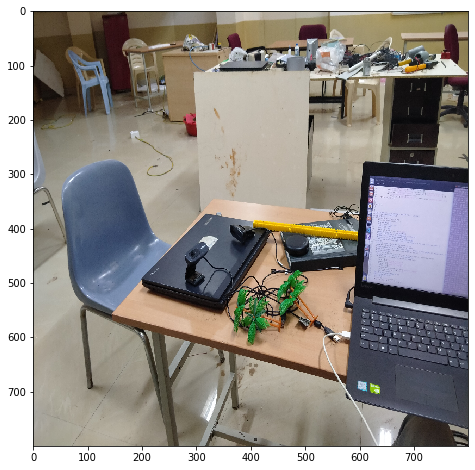

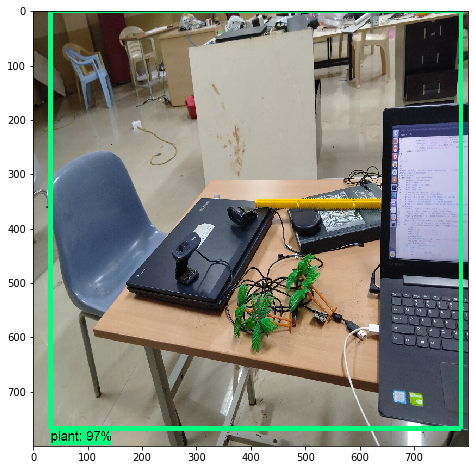

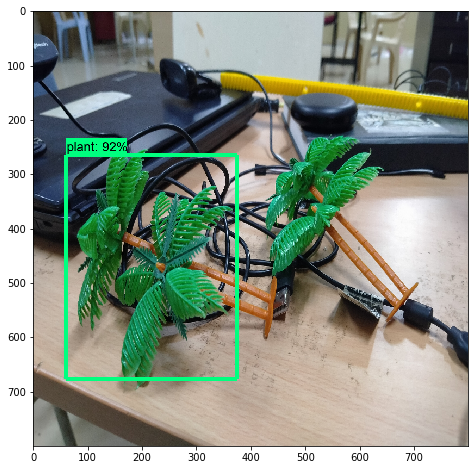

In [28]:
import cv2
%matplotlib inline
#cap = cv2.VideoCapture(1)
#while True:
for image in TEST_IMAGE_PATHS:
    frame=cv2.imread(image)
    cv2.waitKey(10)
    frame=cv2.resize(frame, (800, 800))
    #ret, frame = cap.read()
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(frame)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    image_np=cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    ''' boxes = np.squeeze(output_dict['detection_boxes'])
    scores = np.squeeze(output_dict['detection_scores'])
    #set a min thresh score, say 0.8
    min_score_thresh = 0.8
    bboxes = boxes[scores > min_score_thresh]
    #get image size
    im_width, im_height,xx = image.shape
    detection_centroid = []
    for box in bboxes:
        ymin, xmin, ymax, xmax = box
        final_box=([xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height])
        center=(((final_box[0]+final_box[1])/2),((final_box[0]+final_box[1])/2))
        detection_centroid.append(center)
    if(len(detection_centroid)>1):
        for i in range(len(detection_centroid)):
            x,y=detection_centroid[i]
            x1,y1=detection_centroid[i+1]
            cv2.line(image_np, (x, y),(x1, y1),(0,255,0), 2)
    
    '''
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()

### Benchmark TensorFlow inference speed

In [5]:
import time


def run_inference_benchmark(image, graph, trial=20, gpu=True):
    """Run TensorFlow inference benchmark.

    Arguments:
        image {np.array} -- Input image as an Numpy array.
        graph {tf.Graph} -- TensorFlow graph object.

    Keyword Arguments:
        trial {int} -- Number of inference to run for averaging. (default: {20})
        gpu {bool} -- Use Nvidia GPU when available. (default: {True})

    Returns:
        int -- Frame per seconds benchmark result.
    """

    with graph.as_default():
        if gpu:
            config = tf.ConfigProto()
        else:
            config = tf.ConfigProto(device_count={"GPU": 0})
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                "num_detections",
                "detection_boxes",
                "detection_scores",
                "detection_classes",
                "detection_masks",
            ]:
                tensor_name = key + ":0"
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name
                    )
            if "detection_masks" in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict["detection_boxes"], [0])
                detection_masks = tf.squeeze(tensor_dict["detection_masks"], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict["num_detections"][0], tf.int32
                )
                detection_boxes = tf.slice(
                    detection_boxes, [0, 0], [real_num_detection, -1]
                )
                detection_masks = tf.slice(
                    detection_masks, [0, 0, 0], [real_num_detection, -1, -1]
                )
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1]
                )
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8
                )
                # Follow the convention by adding back the batch dimension
                tensor_dict["detection_masks"] = tf.expand_dims(
                    detection_masks_reframed, 0
                )
            image_tensor = tf.get_default_graph().get_tensor_by_name(
                "image_tensor:0"
            )

            # Run inference
            times = []
            # Kick start the first inference which takes longer and followings.
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
            )
            for i in range(trial):
                start_time = time.time()
                output_dict = sess.run(
                    tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
                )
                delta = time.time() - start_time
                times.append(delta)
            mean_delta = np.array(times).mean()
            fps = 1 / mean_delta
            print("average(sec):{:.3f},fps:{:.2f}".format(mean_delta, fps))

    return fps

image = Image.open(TEST_IMAGE_PATHS[-1])
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection benchmark.
fps = run_inference_benchmark(image_np, detection_graph, trial=20, gpu=False)

average(sec):0.053,fps:18.79


In [4]:
interpreter = tf.lite.Interpreter(model_path=)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get quantization info to know input type
quantization = None
using_type = input_details[0]['dtype']
if dtype is np.uint8:
    quantization = input_details[0]['quantization']

# Get input shape
input_shape = input_details[0]['shape']

# Input tensor
input_data = np.zeros(dtype=using_type, shape=input_shape)

# Set input tensor, run and get output tensor
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

ValueError: Model provided has model identifier 'imag', should be 'TFL3'


In [5]:
tf.__version__

'1.14.0'